CONTRIBUTION: Adithya Sajan

# **CAT AND DOG CLASSIFICATION**

Classifying images is a fundamental task in computer vision.  Our objective is to create a binary classifier in this project that can differentiate between photographs of cats and dogs.  The issues presented by the diversity and variability of real-world images can be effectively addressed by using deep learning techniques, especially convolutional neural networks (CNNs).

# TRAINING MODEL

The dataset used in this project is a labeled collection of cat and dog images. It contains 2400 data of cats and 4990 of dogs.

In [ ]:
import random
import os
import shutil
import tqdm

import cv2
import tqdm
import torch
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt


from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import resnet18
from torchvision import transforms
from torch import nn

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

In [ ]:
cat_list = os.listdir('cat_dog/pet/image/cat')
dog_list = os.listdir('cat_dog/pet/image/dog')
print('cat:',len(cat_list))
print('dog:',len(dog_list))

cat: 2400
dog: 4990


The dataset is divided in the ratio: Train(75%),Val(15%),Test(10%)

In [ ]:
#split 75:15:10
def split_data(lists):
    random.shuffle(lists)
    train_end = int(0.75 * len(lists))
    val_end = train_end + int(0.15 * len(lists))
    train = lists[:train_end]
    val = lists[train_end:val_end]
    test = lists[val_end:]

    return train, val, test

print('Spliting the data for train(75%), val(15%) and test(10%)')
cat_train, cat_val, cat_test = split_data(cat_list)
dog_train, dog_val, dog_test = split_data(dog_list)
print(f"Train: {len(cat_train+dog_train)}")
print(f"Val: {len(cat_val+dog_val)}")
print(f"Test: {len(cat_test+dog_test)}")

Spliting the data for train(75%), val(15%) and test(10%)
Train: 5542
Val: 1108
Test: 740


A deep convolutional neural network architecture called *ResNet (Residual Network)* is used to train the model.

In [ ]:
#resNet18 pre-trained model
model = resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2) #final layer

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 141MB/s]


DataLoader for train, val and test datas.

In [ ]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()])

train_dataset = datasets.ImageFolder(root='data/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = datasets.ImageFolder(root='data/val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

test_dataset = datasets.ImageFolder(root='data/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

In [ ]:
#Label index
print(train_dataset.class_to_idx)  # {'cats': 0, 'dogs': 1}

{'cat': 0, 'dog': 1}


**Evaluation and** **metrics**

In [ ]:
def evaluate(model, loader, metrics):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm.tqdm(loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.append(predicted.cpu())
            all_labels.append(labels.cpu())

    val_acc = correct / total
    print(f"Validation Accuracy: {val_acc:.2f}%\n")
    if metrics:
      all_preds = torch.cat(all_preds).numpy()
      all_labels = torch.cat(all_labels).numpy()

      print(f"F1 Score: {f1_score(all_labels, all_preds, average='macro'):.4f}\n")
      print(f"Precision: {precision_score(all_labels, all_preds, average='macro'):.4f}\n")
      print(f"Recall: {recall_score(all_labels, all_preds, average='macro'):.4f}")
      print(f"Confusion Matrix:\n{confusion_matrix(all_labels, all_preds)}\n")
      print(f"Classification Report:\n{classification_report(all_labels, all_preds)}")


**Training Function**

In [ ]:
#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

#loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


def train_model(model, train_loader, epochs=3):
  for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm.tqdm(train_loader):
      images, labels = images.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()

    train_acc = 100. * correct / total
    print(f"\nEpoch {epoch+1}/{epochs} | Loss: {running_loss:.4f} | Train Acc: {train_acc:.2f}%")

    # validation
    evaluate(model, val_loader, False)


In [ ]:
train_model(model, train_loader, epochs=3)

100%|██████████| 347/347 [16:07<00:00,  2.79s/it]



Epoch 1/3 | Loss: 28.3009 | Train Acc: 96.99%


100%|██████████| 139/139 [08:10<00:00,  3.53s/it]


Validation Accuracy: 1.00%



100%|██████████| 347/347 [02:20<00:00,  2.47it/s]



Epoch 2/3 | Loss: 8.2947 | Train Acc: 99.19%


100%|██████████| 139/139 [00:19<00:00,  6.99it/s]


Validation Accuracy: 1.00%



100%|██████████| 347/347 [02:28<00:00,  2.34it/s]



Epoch 3/3 | Loss: 6.3100 | Train Acc: 99.49%


100%|██████████| 139/139 [00:20<00:00,  6.91it/s]

Validation Accuracy: 1.00%



The model was trained over 3 epochs, and we monitored both the loss and accuracy on the training and validation datasets after each epoch.

 **Final Accuracy Results**:


Training Accuracy (Final Epoch):~ 99%

Validation Accuracy (Final Epoch):~99%

Test Accuracy: ~99%

In [ ]:
evaluate(model, test_loader, True)

100%|██████████| 93/93 [04:47<00:00,  3.09s/it]

Validation Accuracy: 0.99%

F1 Score: 0.9908

Precision: 0.9897

Recall: 0.9918
Confusion Matrix:
[[238   2]
 [  4 496]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       240
           1       1.00      0.99      0.99       500

    accuracy                           0.99       740
   macro avg       0.99      0.99      0.99       740
weighted avg       0.99      0.99      0.99       740



In [ ]:
torch.save(model.state_dict(), "pet.pt")

# XAI methods

In this project, we used three popular XAI (Explainable AI) techniques to interpret our image classification model:


1. Grad-CAM
2. LIME
3. Integrated Gradients








**Loading the model**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load("pet.pt"))
model.to(device)
model.eval()

1. **GradCAM** shows which parts of an image influenced the model’s prediction by creating a heatmap over key regions.
It helps explain and visualize model decisions, especially in CNNs.

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

In [ ]:
to_pil = transforms.ToPILImage()
#cat
cat_image = to_pil(test_dataset[0][0])
cat_image = cat_image.resize((512, 512), resample=Image.Resampling.BILINEAR)
cat_image_np = np.array(cat_image)
cat_input_tensor = transform(cat_image).unsqueeze(0).to(device)

#dog
dog_image = to_pil(test_dataset[260][0])
dog_image = dog_image.resize((512, 512), resample=Image.Resampling.BILINEAR)
dog_image_np = np.array(dog_image)
dog_input_tensor = transform(dog_image).unsqueeze(0).to(device)

target_layer = model.layer4[-1]

cam = GradCAM(model=model, target_layers=[target_layer])

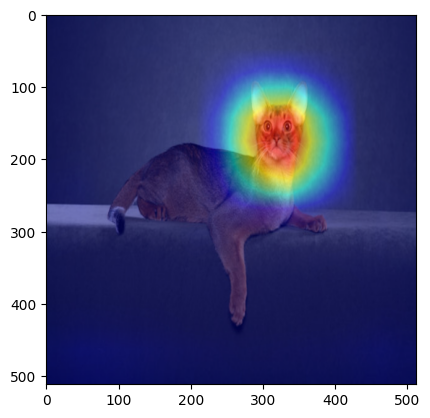

In [ ]:
grayscale_cam = cam(input_tensor=cat_input_tensor)[0, :]
visualization_cat = show_cam_on_image(cat_image_np / 255.0, grayscale_cam, use_rgb=True)
plt.imshow(visualization_cat)

OUTPUT: The model focused on the cat’s face and ears, showing it relied on the right visual features for prediction.

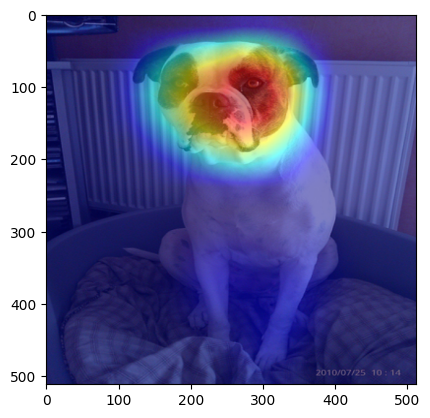

In [ ]:
grayscale_cam = cam(input_tensor=dog_input_tensor)[0, :]
visualization_dog = show_cam_on_image(dog_image_np / 255.0, grayscale_cam, use_rgb=True)
plt.imshow(visualization_dog)

OUTPUT: The attention is centered around the dog’s head and snout, confirming the model used relevant regions for classification.

2. **LIME**(Local Interpretable Model-agnostic Explanations) highlights which parts of an image influenced the model’s prediction by masking regions and observing changes.
It shows what the model "looked at" to make its decision.

In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [ ]:
explainer = lime_image.LimeImageExplainer()

def batch_predict(images):
    model.eval()
    images = torch.stack([transform(Image.fromarray(img)) for img in images], dim=0).to(device)
    outputs = model(images)
    return outputs.detach().cpu().numpy()


  0%|          | 0/1000 [00:00<?, ?it/s]

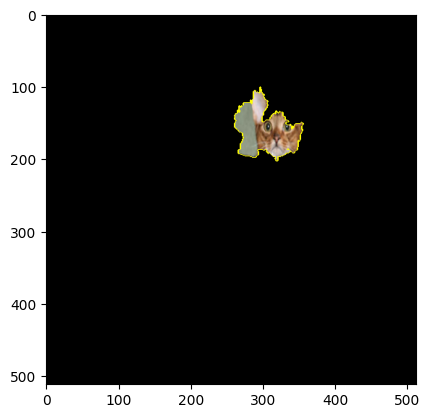

In [ ]:

explanation = explainer.explain_instance(
    image=cat_image_np,
    classifier_fn=batch_predict,
    top_labels=2,
    hide_color=0,
    num_samples=1000
)

# Show explanation
temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    hide_rest=True,
    num_features=5,
    min_weight=0.0
)
lime_img_cat = mark_boundaries(temp / 255.0, mask)
plt.imshow(lime_img_cat)

OUTPUT: Here it highlights distinct features like the cat’s eyes and ears, showing these were key in the classification.

  0%|          | 0/1000 [00:00<?, ?it/s]

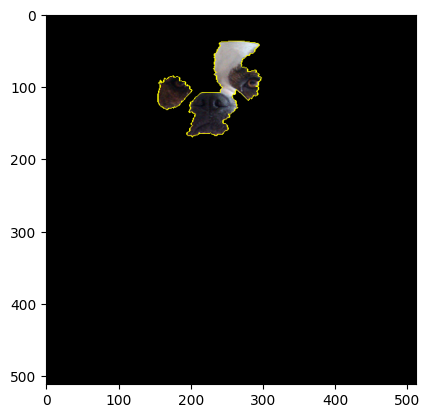

In [ ]:
explanation = explainer.explain_instance(
    image=dog_image_np,classifier_fn=batch_predict,top_labels=2,hide_color=0,num_samples=1000
)

temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],positive_only=True,hide_rest=True,num_features=5,min_weight=0.0
)

lime_img_dog = mark_boundaries(temp / 255.0, mask)
plt.imshow(lime_img_dog)

OUTPUT: The snout and forehead are emphasized, meaning LIME found them most influential in the dog prediction.

3. **Integrated Gradients** explain a model’s prediction by measuring how each pixel contributes, relative to a baseline (like a black image).
It attributes importance to pixels that change the prediction most when moving from baseline to the actual image.

In [ ]:
from captum.attr import IntegratedGradients

In [ ]:
ig = IntegratedGradients(model)

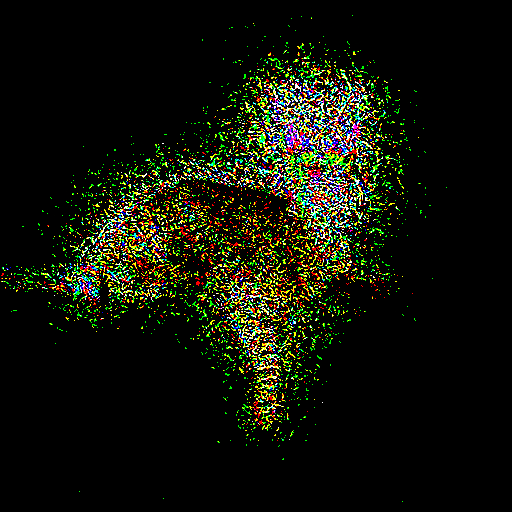

In [ ]:
cat_res = ig.attribute(cat_input_tensor, target=1)
to_pil(cat_res[0])

OUTPUT: The colored pixel clusters focus around the cat’s head and upper body, indicating these regions most influenced the model’s prediction.

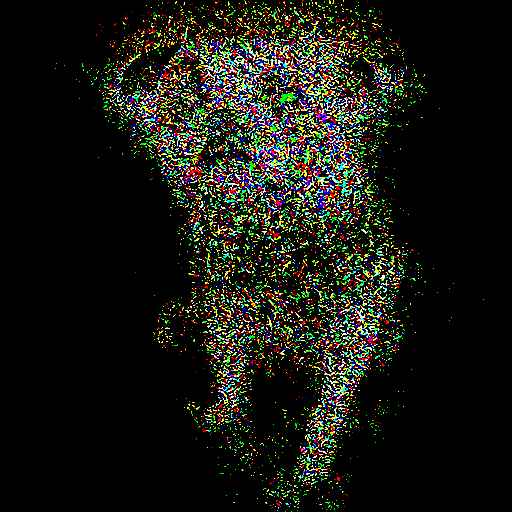

In [ ]:
dog_res = ig.attribute(dog_input_tensor, target=1)
to_pil(dog_res[0])

OUTPUT: Bright, dense attributions are seen around the dog’s face and legs, showing where the model placed the most importance when classifying the image.

# **Comparison of XAI methods**

* Grad-CAM highlights overall regions of interest, helping visualize where the model directs its focus.

* LIME provides targeted explanations by analyzing the impact of specific masked-out sections.

* Integrated Gradients reveals detailed pixel-wise influence, showing how each pixel affects the prediction.

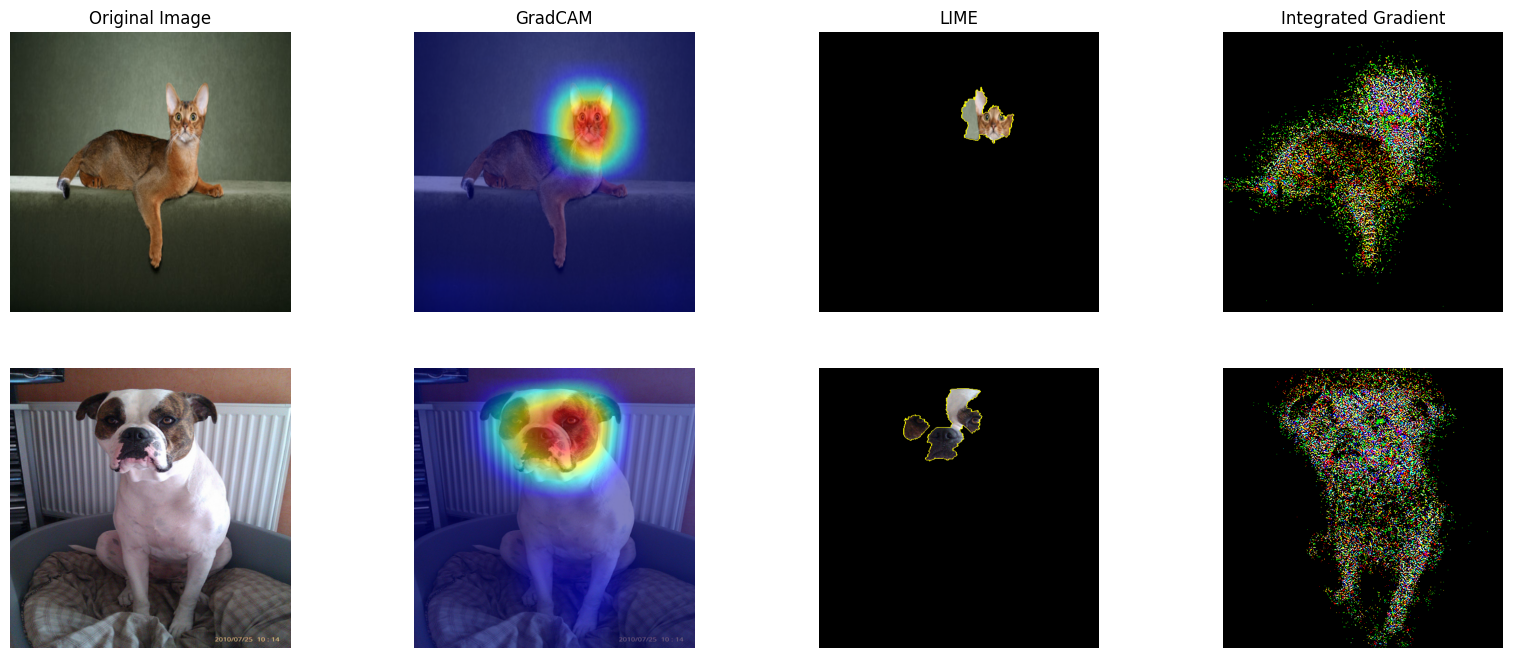

In [ ]:
def plot_image(subplot_index, image, title, cmap=None):
    plt.subplot(2, 4, subplot_index)
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis('off')

plt.figure(figsize=(20, 8))

plot_image(1, cat_image, "Original Image", cmap='gray')
plot_image(2, visualization_cat, "GradCAM")
plot_image(3, lime_img_cat, "LIME")
plot_image(4, to_pil(cat_res[0]), "Integrated Gradient")
plot_image(5, dog_image, "", cmap='gray')
plot_image(6, visualization_dog, "")
plot_image(7, lime_img_dog, "")
plot_image(8, to_pil(dog_res[0]), "")

plt.show()

**Cat Example** (Top Row)
Original Image: Clear frontal view of the cat on a green background.

* Grad-CAM: Strong focus on the cat's face, indicating the model used facial features for classification.

* LIME: Highlights specific superpixels (mostly around the cat's ears and head) that influenced the prediction.

* Integrated Gradients: Shows scattered bright attributions, particularly on the head and upper body, identifying the key regions that contributed to the prediction over a range of intensities.

 **Dog Example** (Bottom Row)
Original Image: A sitting dog with distinct facial features.

* Grad-CAM: Concentrated attention on the dog's face and chest, showing the model focuses on these areas.

* LIME: Highlights a few key patches, mainly around the face, showing localized decision-making.

* Integrated Gradients: Dense color signals around the head, body, and legs, revealing distributed yet relevant pixel importance.

# **LLM Disclosure**

Parts of this report were or refined with the help of a large language model (LLM), specifically ChatGPT by OpenAI.